# Dog Cat classification using 3layered network (Tensorflow)

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [2]:
train_data = np.load('./images_dog_vs_cat_25000.npy')
labels = np.load('./labels_dog_vs_cat_25000.npy')
labels = np.array(labels).reshape((1, -1))

In [3]:
print(train_data.shape)
print(labels.shape)

(2500, 25000)
(1, 25000)


In [4]:
train_data = train_data/255

In [5]:
X = train_data[:,:20000]
Y = labels[:,:20000]
X_test = train_data[:, 20000:]
Y_test = labels[:, 20000:]
print(Y.shape)

(1, 20000)


In [6]:
Y = convert_to_one_hot(Y, 2)
Y_test = convert_to_one_hot(Y_test, 2)
print(Y.shape)

(2, 20000)


In [7]:
def create_placeholders(n_x, n_y):
    
    X = tf.placeholder(tf.float32, shape=(n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = "Y")
    
    return X, Y

In [8]:
def initialize_parameters():
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [25, 2500], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [2,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [9]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                                            # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                             # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                                            # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                                             # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [10]:
def compute_cost(Z3, Y):
    
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

In [11]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Cost after epoch 0: 0.683173
Cost after epoch 10: 0.639109
Cost after epoch 20: 0.615537
Cost after epoch 30: 0.591775
Cost after epoch 40: 0.562029
Cost after epoch 50: 0.537184
Cost after epoch 60: 0.506778
Cost after epoch 70: 0.479745
Cost after epoch 80: 0.453276
Cost after epoch 90: 0.425307
Cost after epoch 100: 0.401143
Cost after epoch 110: 0.377146
Cost after epoch 120: 0.349953
Cost after epoch 130: 0.329320
Cost after epoch 140: 0.310793
Cost after epoch 150: 0.292133
Cost after epoch 160: 0.265389
Cost after epoch 170: 0.248245
Cost after epoch 180: 0.237810
Cost after epoch 190: 0.221739
Cost after epoch 200: 0.206837
Cost after epoch 210: 0.190109
Cost after epoch 220: 0.181559
Cost after epoch 230: 0.163368
Cost after epoch 240: 0.151619
Cost after epoch 250: 0.146074
Cost after ep

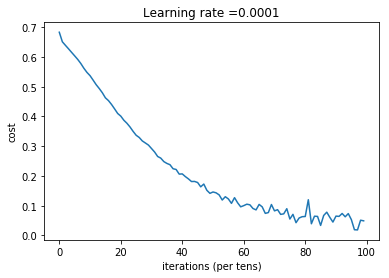

Parameters have been trained!
Train Accuracy: 0.9942
Test Accuracy: 0.5976


In [12]:
parameters = model(X, Y, X_test, Y_test)

In [13]:
np.save('trained_parameters_dog_vs_cat', parameters)

parameters = np.load('./trained_parameters_dog_vs_cat.npy')


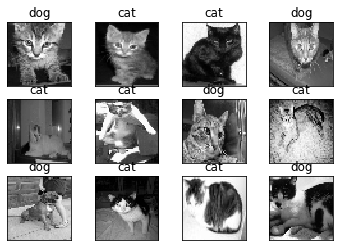

In [14]:
import scipy
from PIL import Image
from scipy import ndimage

my_image = X_test[:,5].reshape((-1,1))

fig=plt.figure()

for num,data in enumerate(X_test[:,:12].T):
    # cat: [1,0]
    # dog: [0,1]
    img_data = data.reshape(-1,1)
    
    y = fig.add_subplot(3,4,num+1)
    my_image_prediction = predict(img_data, parameters)
    
    img_data = img_data.reshape(50, 50)
    y.imshow(img_data,cmap='gray')
    if str(np.squeeze(my_image_prediction)) == "1":
           str_label = "cat"
    else:
           str_label = "dog"
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
